In [1]:
import torch
import norse
from norse.torch.functional.lif_adex import LIFAdExParameters
import norse.torch as snn
import torch.nn as nn
from tqdm import tqdm
from generate_tasks.cognitive_task import (
    ContextDM,
    CompareObjects,
    WorkingMemory,
    MultyTask,
)
from exponent_filter import ExpFilter
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

# print(neuron_parameters)
class SNNMULTYTASK(torch.nn.Module):
    def __init__(
        self, feature_size, hidden_size, output_size, neuron_parameters
    ) -> None:
        super(SNNMULTYTASK, self).__init__()
        # self.poisson = snn.PoissonEncoder(100)
        # self.lif0 = snn.LIFRecurrent(feature_size, hidden_size)
        self.alif = snn.LIFAdExRecurrent(feature_size, hidden_size, p=neuron_parameters)
        # self.lif = snn.LIFRecurrent(feature_size, hidden_size)
        self.exp_f = ExpFilter(hidden_size, output_size, 0.8)
        # self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # out, state = self.lif0(x)
        out, state = self.alif(x)
        # out = self.linear(out)
        out = self.exp_f(out)
        return (out, state)

Device: gpu (cuda)


In [2]:
import numpy as np

# 0. Create dataset


batch_size = 20
task_list = [("WorkingMemory", dict()), (("ContextDM", dict()))]
tasks = dict(task_list)
CDM_task = MultyTask(tasks, batch_size=batch_size)
# inputs, labels, ob_size, act_size = CDM_task.dataset()


feature_size, output_size = CDM_task.feature_and_act_size[0]
hidden_size = 400

# 1. model


neuron_parameters = LIFAdExParameters(
    tau_ada_inv=torch.Tensor([2]).to(device), alpha=100
)
model = SNNMULTYTASK(feature_size, hidden_size, output_size, neuron_parameters).to(
    device
)
with torch.no_grad():
    weights_pre_l = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())
            # print (name, param.data)

# 2. loss and optimizer
learning_rate = 5e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
criterion_test = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.85))
running_loss = 0.0

In [3]:
# 3. train loop
%matplotlib
# fig, ax = plt.subplots()
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
inputs, target_outputs = CDM_task.dataset(10)
(line1,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line2,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
(line3,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line4,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([0, 20000])
for i in tqdm(range(1000)):
    inputs, target_outputs = CDM_task.dataset(10)
    inputs += np.random.normal(0, 0.01, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print("epoch: {:d} loss: {:0.5f}".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = CDM_task.dataset(10)

            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs, states = model(inputs)
            loss = criterion_test(outputs, target_outputs)

            print("test loss: {:0.5f}".format(loss.item()))
        for_plot = outputs.detach().cpu().numpy()[:, 0, :]
        line1.set_xdata(np.arange(0, len(for_plot), 1))
        line2.set_xdata(np.arange(0, len(for_plot), 1))
        line3.set_xdata(np.arange(0, len(for_plot), 1))
        line4.set_xdata(np.arange(0, len(for_plot), 1))
        line1.set_ydata(for_plot[:, 1])

        # line1.set_xdata(np.arange(0, len(for_plot)))
        line2.set_ydata(for_plot[:, 2])
        line3.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 1])
        line4.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 2])
        # line2.set_xdata(np.arange(0, len(for_plot)))
    fig.canvas.draw()
    fig.canvas.flush_events()


print("Finished Training")

Using matplotlib backend: TkAgg


  1%|          | 9/1000 [02:48<5:12:06, 18.90s/it]

epoch: 10 loss: 0.22581


  1%|          | 10/1000 [03:13<5:43:10, 20.80s/it]

test loss: 0.16590


  2%|▏         | 19/1000 [06:00<5:10:20, 18.98s/it]

epoch: 20 loss: 0.13706


  2%|▏         | 20/1000 [06:26<5:40:24, 20.84s/it]

test loss: 0.10335


  3%|▎         | 29/1000 [09:13<5:06:23, 18.93s/it]

epoch: 30 loss: 0.08257


  3%|▎         | 30/1000 [09:39<5:38:55, 20.96s/it]

test loss: 0.07422


  4%|▍         | 39/1000 [12:27<5:06:08, 19.11s/it]

epoch: 40 loss: 0.06024


  4%|▍         | 40/1000 [12:53<5:36:23, 21.02s/it]

test loss: 0.05561


  5%|▍         | 49/1000 [15:40<5:01:08, 19.00s/it]

epoch: 50 loss: 0.05317


  5%|▌         | 50/1000 [16:05<5:28:18, 20.74s/it]

test loss: 0.05976


  6%|▌         | 59/1000 [18:51<4:53:10, 18.69s/it]

epoch: 60 loss: 0.04854


  6%|▌         | 60/1000 [19:16<5:19:44, 20.41s/it]

test loss: 0.04815


  7%|▋         | 69/1000 [21:58<4:46:02, 18.43s/it]

epoch: 70 loss: 0.04798


  7%|▋         | 70/1000 [22:22<5:13:22, 20.22s/it]

test loss: 0.04289


  8%|▊         | 79/1000 [25:04<4:39:58, 18.24s/it]

epoch: 80 loss: 0.04567


  8%|▊         | 80/1000 [25:28<5:07:48, 20.07s/it]

test loss: 0.04608


  9%|▉         | 89/1000 [28:09<4:36:10, 18.19s/it]

epoch: 90 loss: 0.04725


  9%|▉         | 90/1000 [28:33<5:03:31, 20.01s/it]

test loss: 0.05939


 10%|▉         | 99/1000 [31:21<4:46:13, 19.06s/it]

epoch: 100 loss: 0.04620


 10%|█         | 100/1000 [31:47<5:15:56, 21.06s/it]

test loss: 0.03758


 11%|█         | 109/1000 [34:36<4:45:12, 19.21s/it]

epoch: 110 loss: 0.04318


 11%|█         | 110/1000 [35:01<5:11:04, 20.97s/it]

test loss: 0.04023


 12%|█▏        | 119/1000 [37:51<4:43:40, 19.32s/it]

epoch: 120 loss: 0.03906


 12%|█▏        | 120/1000 [38:17<5:10:08, 21.15s/it]

test loss: 0.05585


 13%|█▎        | 129/1000 [41:03<4:33:00, 18.81s/it]

epoch: 130 loss: 0.04237


 13%|█▎        | 130/1000 [41:28<5:00:06, 20.70s/it]

test loss: 0.05535


 14%|█▍        | 139/1000 [44:14<4:31:12, 18.90s/it]

epoch: 140 loss: 0.03968


 14%|█▍        | 140/1000 [44:39<4:55:57, 20.65s/it]

test loss: 0.04453


 15%|█▍        | 149/1000 [47:24<4:25:45, 18.74s/it]

epoch: 150 loss: 0.04171


 15%|█▌        | 150/1000 [47:49<4:53:22, 20.71s/it]

test loss: 0.03036


 16%|█▌        | 159/1000 [50:35<4:23:14, 18.78s/it]

epoch: 160 loss: 0.03934


 16%|█▌        | 160/1000 [51:00<4:48:31, 20.61s/it]

test loss: 0.03535


 17%|█▋        | 169/1000 [53:47<4:21:05, 18.85s/it]

epoch: 170 loss: 0.03771


 17%|█▋        | 170/1000 [54:12<4:47:09, 20.76s/it]

test loss: 0.04499


 18%|█▊        | 179/1000 [56:58<4:16:34, 18.75s/it]

epoch: 180 loss: 0.04411


 18%|█▊        | 180/1000 [57:22<4:40:17, 20.51s/it]

test loss: 0.03052


 19%|█▉        | 189/1000 [1:00:07<4:13:08, 18.73s/it]

epoch: 190 loss: 0.03828


 19%|█▉        | 190/1000 [1:00:32<4:38:00, 20.59s/it]

test loss: 0.03920


 20%|█▉        | 199/1000 [1:03:19<4:14:29, 19.06s/it]

epoch: 200 loss: 0.03691


 20%|██        | 200/1000 [1:03:44<4:37:17, 20.80s/it]

test loss: 0.03452


 21%|██        | 209/1000 [1:06:31<4:10:12, 18.98s/it]

epoch: 210 loss: 0.03883


 21%|██        | 210/1000 [1:06:56<4:34:42, 20.86s/it]

test loss: 0.03043


 22%|██▏       | 219/1000 [1:09:47<4:12:39, 19.41s/it]

epoch: 220 loss: 0.03680


 22%|██▏       | 220/1000 [1:10:13<4:37:36, 21.35s/it]

test loss: 0.03736


 23%|██▎       | 229/1000 [1:13:03<4:07:44, 19.28s/it]

epoch: 230 loss: 0.03375


 23%|██▎       | 230/1000 [1:13:28<4:30:58, 21.11s/it]

test loss: 0.03949


 24%|██▍       | 239/1000 [1:16:18<4:02:22, 19.11s/it]

epoch: 240 loss: 0.03749


 24%|██▍       | 240/1000 [1:16:43<4:24:40, 20.90s/it]

test loss: 0.03379


 25%|██▍       | 249/1000 [1:19:31<4:00:40, 19.23s/it]

epoch: 250 loss: 0.03633


 25%|██▌       | 250/1000 [1:19:56<4:22:29, 21.00s/it]

test loss: 0.05592


 26%|██▌       | 259/1000 [1:22:42<3:50:43, 18.68s/it]

epoch: 260 loss: 0.03261


 26%|██▌       | 260/1000 [1:23:07<4:13:52, 20.58s/it]

test loss: 0.02109


 27%|██▋       | 269/1000 [1:25:53<3:48:09, 18.73s/it]

epoch: 270 loss: 0.03638


 27%|██▋       | 270/1000 [1:26:18<4:08:25, 20.42s/it]

test loss: 0.04118


 28%|██▊       | 279/1000 [1:29:03<3:45:52, 18.80s/it]

epoch: 280 loss: 0.03292


 28%|██▊       | 280/1000 [1:29:28<4:06:45, 20.56s/it]

test loss: 0.06229


 29%|██▉       | 289/1000 [1:32:12<3:40:38, 18.62s/it]

epoch: 290 loss: 0.03604


 29%|██▉       | 290/1000 [1:32:37<4:02:06, 20.46s/it]

test loss: 0.02661


 30%|██▉       | 299/1000 [1:35:22<3:37:28, 18.61s/it]

epoch: 300 loss: 0.03303


 30%|███       | 300/1000 [1:35:47<3:57:31, 20.36s/it]

test loss: 0.05090


 31%|███       | 309/1000 [1:38:27<3:28:29, 18.10s/it]

epoch: 310 loss: 0.03908


 31%|███       | 310/1000 [1:38:51<3:48:35, 19.88s/it]

test loss: 0.04643


 32%|███▏      | 319/1000 [1:41:40<3:38:27, 19.25s/it]

epoch: 320 loss: 0.03143


 32%|███▏      | 320/1000 [1:42:06<3:59:14, 21.11s/it]

test loss: 0.02471


 33%|███▎      | 329/1000 [1:44:57<3:33:06, 19.06s/it]

epoch: 330 loss: 0.03458


 33%|███▎      | 330/1000 [1:45:22<3:52:37, 20.83s/it]

test loss: 0.03254


 34%|███▍      | 339/1000 [1:48:10<3:30:09, 19.08s/it]

epoch: 340 loss: 0.02993


 34%|███▍      | 340/1000 [1:48:35<3:50:31, 20.96s/it]

test loss: 0.03589


 35%|███▍      | 349/1000 [1:51:23<3:25:44, 18.96s/it]

epoch: 350 loss: 0.03201


 35%|███▌      | 350/1000 [1:51:47<3:42:30, 20.54s/it]

test loss: 0.03567


 36%|███▌      | 359/1000 [1:54:37<3:24:51, 19.18s/it]

epoch: 360 loss: 0.03394


 36%|███▌      | 360/1000 [1:55:02<3:42:44, 20.88s/it]

test loss: 0.02462


 37%|███▋      | 369/1000 [1:57:51<3:19:49, 19.00s/it]

epoch: 370 loss: 0.03543


 37%|███▋      | 370/1000 [1:58:16<3:40:13, 20.97s/it]

test loss: 0.02202


 38%|███▊      | 379/1000 [2:01:07<3:22:01, 19.52s/it]

epoch: 380 loss: 0.03042


 38%|███▊      | 380/1000 [2:01:33<3:42:31, 21.53s/it]

test loss: 0.04327


 39%|███▉      | 389/1000 [2:04:27<3:18:02, 19.45s/it]

epoch: 390 loss: 0.03171


 39%|███▉      | 390/1000 [2:04:51<3:33:07, 20.96s/it]

test loss: 0.03930


 40%|███▉      | 399/1000 [2:07:36<3:06:07, 18.58s/it]

epoch: 400 loss: 0.03381


 40%|████      | 400/1000 [2:08:00<3:22:19, 20.23s/it]

test loss: 0.03232


 41%|████      | 409/1000 [2:10:47<3:09:05, 19.20s/it]

epoch: 410 loss: 0.03084


 41%|████      | 410/1000 [2:11:13<3:29:44, 21.33s/it]

test loss: 0.02749


 42%|████▏     | 418/1000 [2:14:08<3:06:46, 19.26s/it]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
for i in range(100):
    x = np.arange(100)
    y = np.full([100], fill_value=i)
    plot_something_live(ax, y)

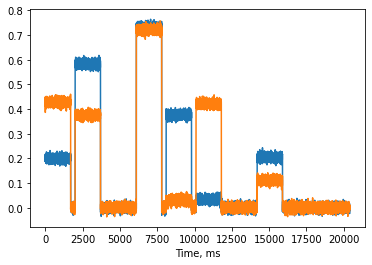

inputs.shape = (20394, 1, 8)
outputs.shape = (20394, 1, 5)


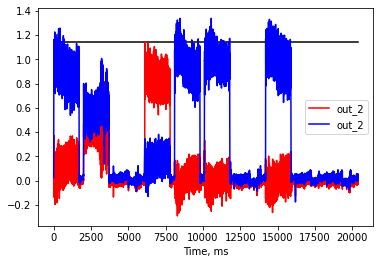

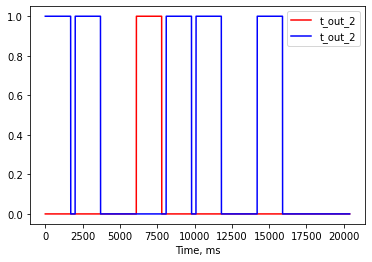

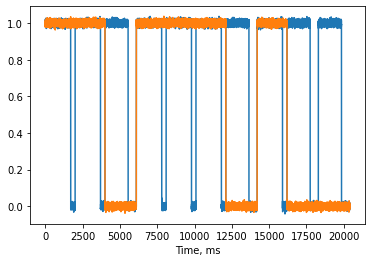

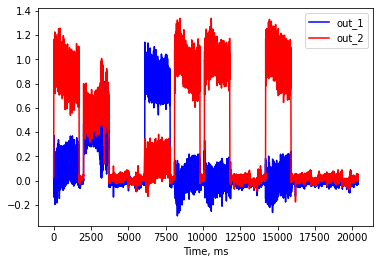

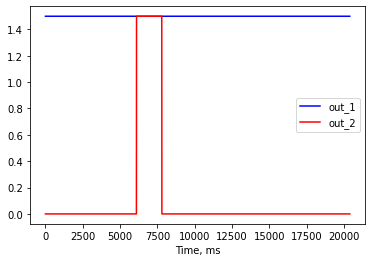

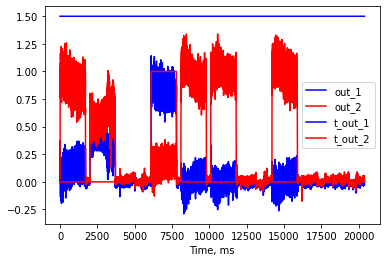

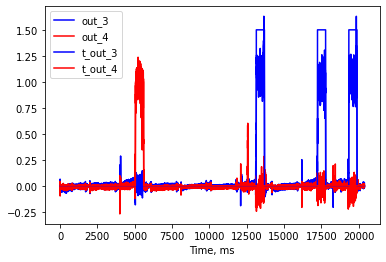

In [8]:

# 0. Create dataset
%matplotlib inline
dt = 1e-3

batch_size = 1
CDM_task = MultyTask(tasks=tasks, batch_size=batch_size)
inputs, labels = CDM_task.dataset(10)
inputs += np.random.normal(0, .01, size=(inputs.shape))
plt.plot(inputs[:, 0, 3])
plt.plot(inputs[:, 0, 4])
plt.xlabel('Time, ms')
plt.show()
plt.close()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)  
feature_size, output_size = CDM_task.feature_and_act_size

# 1. model

if False:
    
    model = SNNMULTYTASK(feature_size, hidden_size, output_size).to(device)
    with torch.no_grad():
        for name, param in model.named_parameters(): 
            param.copy_(torch.from_numpy( np.load(f'./data/{name}.npy')).to(device))
#labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
with torch.no_grad():
    outputs, state = model(inputs)
    inputs = inputs.cpu().numpy() 
    outputs = outputs.cpu().numpy()
    print(f'inputs.shape = {inputs.shape}')
    print(f'outputs.shape = {outputs.shape}')
    plt.plot([0, len(labels)], [np.max(outputs[:, 0, 1])] * 2, c='black')
    plt.plot(outputs[:, 0, 1], label='out_2', c='r')
    plt.plot(outputs[:, 0, 2], label='out_2', c='b')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(labels[:, 0, 1]  , label='t_out_2', c='r')
    plt.plot(labels[:, 0, 2]  , label='t_out_2', c='b')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    #plt.plot(labels[:, 0, 0])
    plt.plot(inputs[:, 0, 0])
    plt.plot(inputs[:, 0, 1])
    #plt.xlim([0, 1000])
    plt.xlabel('Time, ms')
    plt.show()
    plt.close()
    #plt.plot(outputs[:, 0, 2])
    #plt.plot(outputs[:, 0, 0] + 1)
    plt.plot(outputs[:, 0, 1], label='out_1', c='b')
    plt.plot(outputs[:, 0, 2], label='out_2', c='r')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(labels[:, 0, 0] * 1.5 , label='out_1', c='b')
    plt.plot(labels[:, 0, 1] * 1.5 , label='out_2', c='r')
    #plt.xlim([0, 300])
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(outputs[:, 0, 1], label='out_1', c='b')
    plt.plot(outputs[:, 0, 2], label='out_2', c='r')

    plt.plot(labels[:, 0, 0] * 1.5 , label='t_out_1', c='b')
    plt.plot(labels[:, 0, 1]  , label='t_out_2', c='r')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(outputs[:, 0, 3], label='out_3', c='b')
    plt.plot(outputs[:, 0, 4], label='out_4', c='r')

    plt.plot(labels[:, 0, 3] * 1.5 , label='t_out_3', c='b')
    plt.plot(labels[:, 0, 4]  , label='t_out_4', c='r')
    plt.xlabel('Time, ms')
    plt.legend()
    plt.show()
    plt.close()


    


In [ ]:
torch.save(model.state_dict(), "./saved_models/1_0_two_task")